In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix


from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load processed datasets
df_train = pd.read_csv("train_data_feature_engineered.csv")
df_test = pd.read_csv("test_data_feature_engineered.csv")

In [3]:
# Check if there are any rows where Total_Traffic is 0
zero_traffic_rows_train = df_train[df_train["Total_Traffic"] == 0]
zero_traffic_rows_test = df_test[df_test["Total_Traffic"] == 0]

# Print the count of rows with Total_Traffic == 0
print("Rows with 0 Total_Traffic in train data:", len(zero_traffic_rows_train))
print("Rows with 0 Total_Traffic in test data:", len(zero_traffic_rows_test))


Rows with 0 Total_Traffic in train data: 2
Rows with 0 Total_Traffic in test data: 0


In [4]:
# Remove rows where Total_Traffic is 0
df_train = df_train[df_train["Total_Traffic"] > 0]

# Apply qcut on training data
df_train["Traffic_Class"], bins = pd.qcut(df_train["Total_Traffic"], q=3, labels=[0, 1, 2], retbins=True)
# Apply the same bins from training to test data
df_test["Traffic_Class"] = pd.cut(df_test["Total_Traffic"], bins=bins, labels=[0, 1, 2], include_lowest=True)


In [5]:
print("Bin edges:", bins)

Bin edges: [3.05000000e+02 1.02221000e+05 2.93217333e+05 2.70706400e+06]


Based on the bin edges, it can be interpreted as the following:

First bin: From 302 to 102,221.00 (Low Traffic)

Second bin: From 102,221.00 to 293,217.33 (Medium Traffic)

Third bin: From 293,217.33 to 2,707,064.00 (High Traffic)

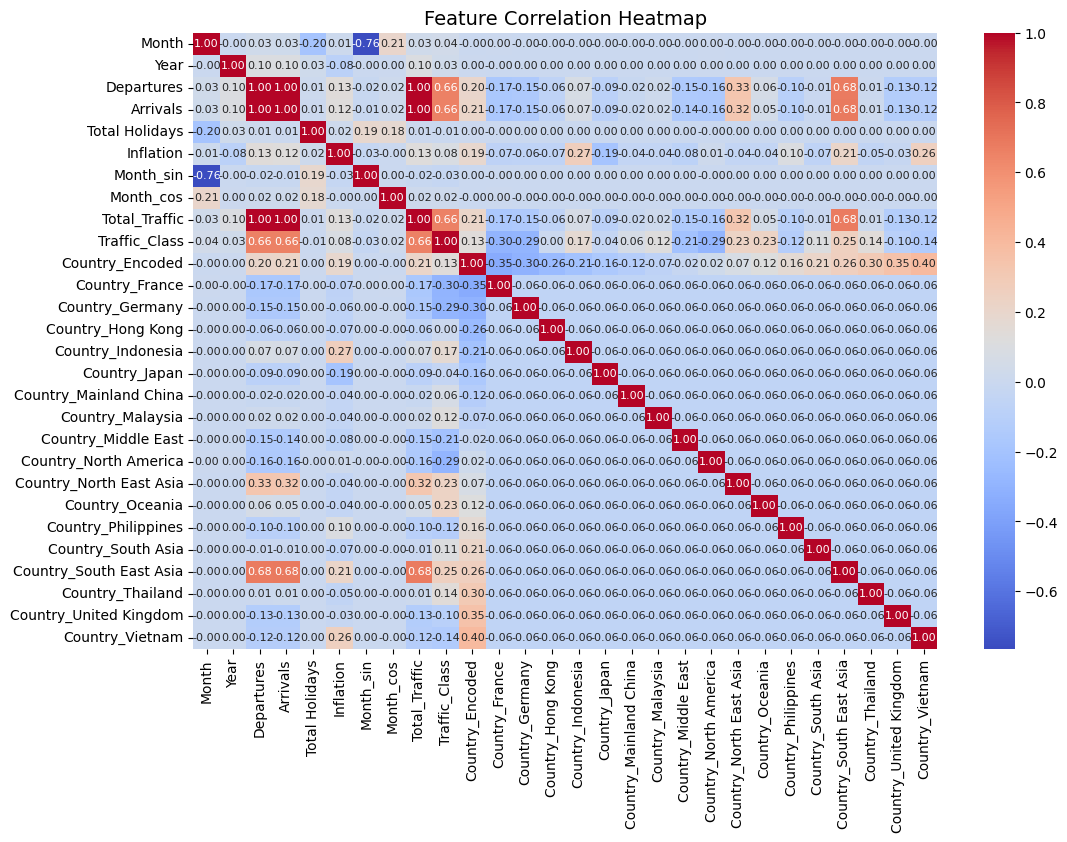

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_train["Country_Encoded"] = encoder.fit_transform(df_train["Country"])
df_train = pd.get_dummies(df_train, columns=["Country"], drop_first=True)

correlation_matrix = df_train.corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(12, 8))

# Generate heatmap with smaller annotations
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 8})

# Adjust title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Show plot
plt.show()


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define target and features
X = df_train.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
# Encode categorical variables
X = pd.get_dummies(X, columns=["Country"], drop_first=True)  # One-hot encoding
y = df_train["Traffic_Class"]  # Target


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#regularization 
# Train Random Forest
clf = RandomForestClassifier(
    n_estimators=100,        # More trees for stability
    max_depth=10,            # Limits how deep each tree can grow
    min_samples_split=5,     # Minimum samples needed to split a node
    min_samples_leaf=2,      # Minimum samples needed in a leaf node
    max_features="sqrt",     # Reduces correlation between trees
    random_state=42
)

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9040268456375838


In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score


# Define target and features
X_test2 = df_test.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
y_test2 = df_test["Traffic_Class"]  # Target

# Encode categorical variables
X_test2 = pd.get_dummies(X_test2, columns=["Country"], drop_first=True)  # One-hot encoding

# Extract true labels
y_test2 = df_test["Traffic_Class"]  # Make sure this column exists in test_data.csv

# Predict and evaluate
y_pred2 = clf.predict(X_test2)
print("Accuracy:", accuracy_score(y_test2, y_pred2))

Accuracy: 0.32293986636971045


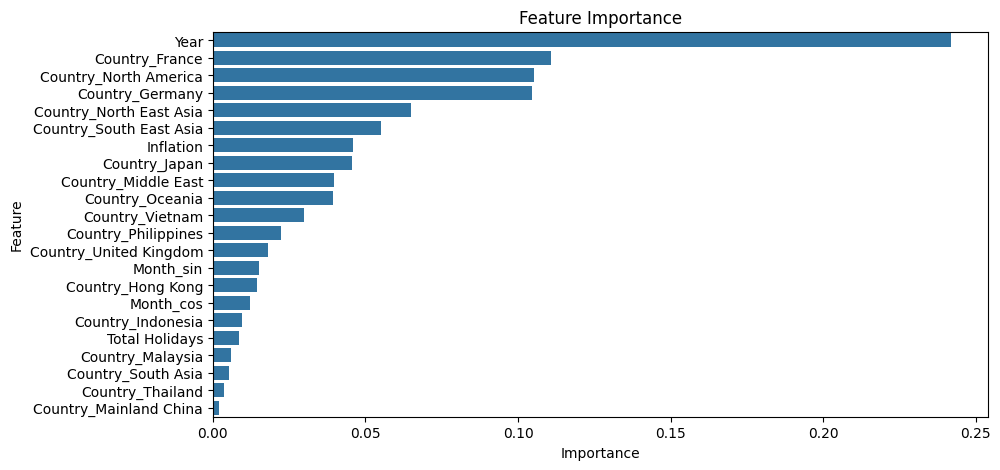

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = clf.feature_importances_

# Create a DataFrame for visualization
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance")
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],  # Prevent trees from growing too deep
    "min_samples_split": [2, 5, 10],  # Avoid splitting on small changes
    "min_samples_leaf": [1, 2, 5],  # Prevent too specific leaf nodes
    "max_features": ["sqrt", "log2"]  # Reduce feature correlation
}

# Create a RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)


# Set up GridSearchCV with cross-validation (cv=5 for 5-fold cross-validation)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Train model with best hyperparameters
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [14]:
# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Use the best model found by grid search to make predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_acc:.4f}")
print(f"Test Balanced Accuracy: {test_acc:.4f}")


Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Train Accuracy: 0.9655
Test Accuracy: 0.9208
Train Balanced Accuracy: 0.9655
Test Balanced Accuracy: 0.9208


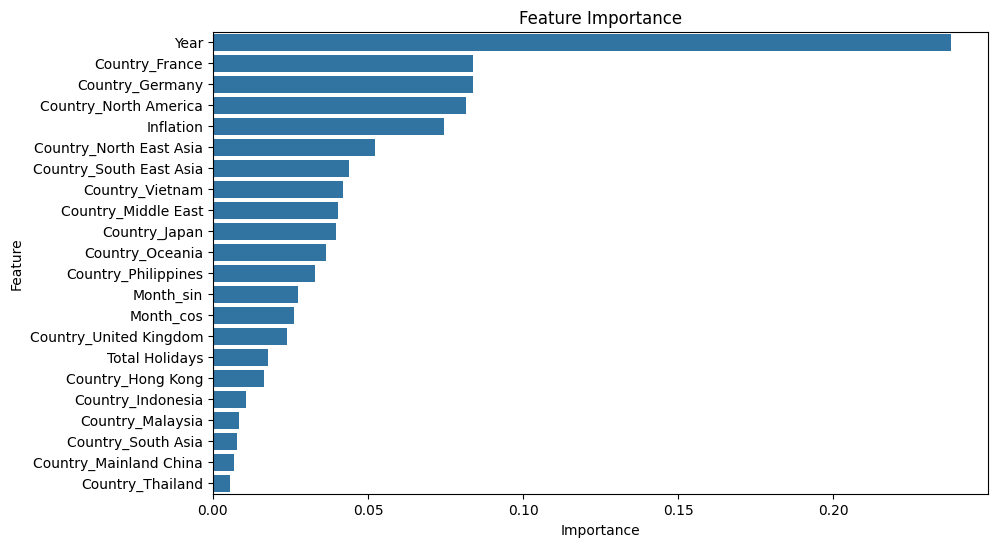

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importance = best_rf.feature_importances_

# Create a DataFrame for easy visualization
feat_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance")
plt.show()


In [16]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation with the best model
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy') #10-fold

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")


Cross-Validation Scores: [0.8908046  0.94252874 0.93103448 0.92528736 0.94252874 0.89913545
 0.89913545 0.90201729 0.89913545 0.93659942]
Mean Cross-Validation Accuracy: 0.9168


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       474
           1       0.87      0.91      0.89       503
           2       0.96      0.91      0.93       513

    accuracy                           0.92      1490
   macro avg       0.92      0.92      0.92      1490
weighted avg       0.92      0.92      0.92      1490



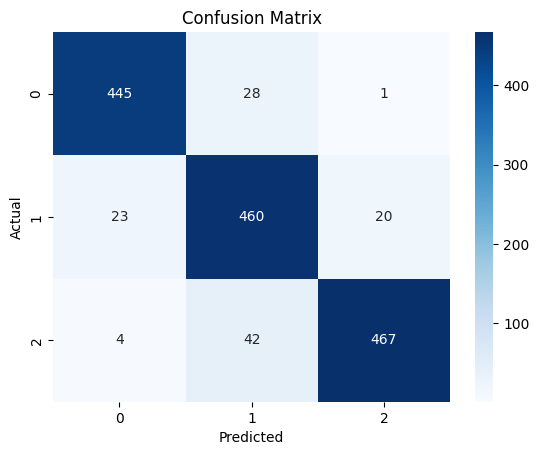

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [18]:
# Save Traffic_Class to train and test CSV files - final one

# Save the train DataFrame with the new Traffic_Class column
df_train.to_csv('train_data_with_traffic_class.csv', index=False)

# Save the test DataFrame with the new Traffic_Class column
df_test.to_csv('test_data_with_traffic_class.csv', index=False)

print("Files saved with Traffic_Class column!")


Files saved with Traffic_Class column!
